# Experiment Pipeline DUCKNet

In [1]:
#To save configs and figures
import os
from pathlib import Path
from configs import CONFIG_DIR
from figures import FIGURES_DIR

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from hubmap.data import DATA_DIR
from hubmap.dataset import TrainDataset, ValDataset
from hubmap.dataset import transforms as T

#loss and metric functions
from hubmap.experiments.DUCKNet.utils import run
from hubmap.experiments.DUCKNet.utils import DiceBCELoss
from hubmap.experiments.DUCKNet.utils import visualize_detailed_results
from hubmap.experiments.DUCKNet.utils import visualize_detailed_results_overlay

from hubmap.training import LRScheduler
from hubmap.training import EarlyStopping

from hubmap.models.ducknet import DUCKNet, DUCKNetPretrained, DUCKNetPretrained34

import matplotlib.pyplot as plt
from hubmap.visualization import visualize_result

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is: ", device)

c:\Users\gulBa\AppData\Local\pypoetry\Cache\virtualenvs\hubmap-nJ1voaj--py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device is:  cuda


# 1. Data

**Augmentations**, one for training data and one for testing

In [2]:
# MINIMUM SIZE OF IMAGES FOR MODEL INPUT IS 64x64
IMG_SIZE = 128

train_transformations = T.Compose(
    [
        T.ToTensor(),
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomCrop((IMG_SIZE, IMG_SIZE)),
    ]
)

val_transformations = T.Compose(
    [
        T.ToTensor(),
        T.Resize((IMG_SIZE, IMG_SIZE)),
    ]
)

**Data Loading**
- with_background
- as_id_mask

In [3]:
train_set = TrainDataset(DATA_DIR, transform=train_transformations, with_background=True)
val_set = ValDataset(DATA_DIR, transform=val_transformations, with_background=True)

## 2. MODEL

#### 2.1. Model Parameters:

In [4]:
name = 'ducknet_focal_128_20'
CHECKPOINT = name
CHECKPOINT_NAME = name
MODEL = DUCKNet
NUM_EPOCHS = 20
BATCH_SIZE = 24
CONTINUE_TRAINING = False
EARLY_STOPPING = False
PRETRAINED = True

USE_LR_SCHEDULER = False
LRS_PATIENCE = 10
LR = 1e-3

WEIGHT = torch.tensor([0.4, 0.15, 0.15, 0.3])
CHECKPOINT = name



train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
FIGURES_CHECKPOINT_PATH = Path(FIGURES_DIR, "DUCKNet", f"{CHECKPOINT}")
os.makedirs(FIGURES_CHECKPOINT_PATH, exist_ok=True)

CHECKPOINT_FILE_NAME = f"{CHECKPOINT}.pt"
CHECKPOINT_NAME = Path("DUCKNet", CHECKPOINT_FILE_NAME)
config = {
    "model": "DUCKNet",
    "image_size": IMG_SIZE,
    "num_epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "checkpoint_name": CHECKPOINT_NAME,
    "use_lr_scheduler": False,
    "lr_scheduler_patience": LRS_PATIENCE,
    "use_early_stopping": EARLY_STOPPING is not None,
    "loss": 'FocalLoss',
    "lr": LR,
    "pretrained": PRETRAINED,
    "figures_directory": FIGURES_CHECKPOINT_PATH,
    "weight": WEIGHT
}
os.makedirs(Path(CONFIG_DIR / CHECKPOINT_NAME).parent.resolve(), exist_ok=True)
torch.save(config, Path(CONFIG_DIR / CHECKPOINT_NAME))

#### 2.2. Training


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from hubmap.experiments.DUCKNet.utils import DiceLoss, DiceBCELoss, ChannelWeightedDiceBCELoss
    
class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = nn.functional.cross_entropy(input, target, reduction='none')  # Shape: (batch_size, H, W)
        pt = torch.exp(-ce_loss)
        alpha_t = self.alpha[target.view(-1)].view(target.size())  # Reshape alpha to match target shape
        loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [7]:
model = DUCKNet(input_channels=3, out_classes=4, starting_filters=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

# alpha = torch.tensor([2.8, 0.2, 0.1, 1.0]).to(device) # More weight to blood_vessel, glomerulus, and unsure
criterion = FocalLoss(alpha=WEIGHT.to(device))
lr_scheduler = LRScheduler(optimizer, patience=5)



# lrs = MultiStepLR(optimizer, milestones=[10], gamma=0.1)
# lr_scheduler = lambda _: lrs.step()
early_stopping = None

# alpha = torch.tensor([2.8, 0.2, 0.1, 1.0]).to(device) # More weight to blood_vessel, glomerulus, and unsure
# criterion = FocalLoss(alpha=alpha)

Starting DUCK-Net


In [8]:
# result = run(
#     num_epochs=NUM_EPOCHS,
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     optimizer=optimizer,
#     criterion=criterion,
#     device=device,
#     early_stopping=early_stopping,
#     lr_scheduler=None,
#     checkpoint_name=CHECKPOINT_NAME,
#     continue_training=CONTINUE_TRAINING,
# )

In [9]:
n_epochs = NUM_EPOCHS
lr = LR

def compute_accuracy(pred, target):
    correct = (pred == target).float().sum()
    total = target.numel()
    return (correct / total).item()

# Initialize variables to track training and validation loss, accuracy, and IoU
train_losses = []
train_accuracies = []
train_ious = []  # Added for IoU
val_losses = []
val_accuracies = []
val_ious = []    # Added for IoU

def iou_score(output, target):
    ious = []
    for class_idx in range(4):  # Assuming 4 classes
        output_class = (output == class_idx)
        target_class = (target == class_idx)
        intersection = (output_class & target_class).float().sum()
        union = (output_class | target_class).float().sum()
        ious.append(intersection / (union + 1e-6))  # Avoid division by zero
    return ious

for epoch in range(n_epochs):
    print("start epoch")
    model.train()
    train_loss = 0
    total_train_accuracy = 0 # Added
    mean_iou = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = torch.argmax(masks, dim=1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        preds = torch.argmax(outputs, dim=1) # Added
        ious = iou_score(preds, masks)
        mean_iou += torch.mean(torch.tensor(ious)).item()  # Use torch instead of numpy

        accuracy = compute_accuracy(preds, masks) # Added
        total_train_accuracy += accuracy # Added

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(total_train_accuracy / len(train_loader)) # Added
    train_ious.append(mean_iou / len(train_loader))  # Added

    # Evaluation phase
    model.eval()
    val_loss = 0
    total_accuracy = 0
    mean_val_iou = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = torch.argmax(masks, dim=1).to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = torch.argmax(outputs, dim=1)
            
            class_counts = [torch.sum(preds == i).item() for i in range(4)]
            # print(f'Class counts in predictions: {class_counts}')

            # Inside the validation loop
            ious = iou_score(preds, masks)
            mean_val_iou += torch.mean(torch.tensor(ious)).item()  # Use torch instead of numpy

            accuracy = compute_accuracy(preds, masks)
            total_accuracy += accuracy
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(total_accuracy / len(val_loader))
    val_ious.append(mean_val_iou / len(val_loader))  # Added
    print(f'Epoch {epoch}/{n_epochs}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Val Loss: {val_losses[-1]}, Val Accuracy: {val_accuracies[-1]}')

start epoch
Epoch 0/20, Train Loss: 0.18196553278427857, Train Accuracy: 0.8213782402185293, Val Loss: 0.14490431411699814, Val Accuracy: 0.9202617461031134
start epoch
Epoch 1/20, Train Loss: 0.13492299071871316, Train Accuracy: 0.9081300290731283, Val Loss: 0.11508065326647325, Val Accuracy: 0.9339918873526833
start epoch
Epoch 2/20, Train Loss: 0.10866575243954475, Train Accuracy: 0.907251965541106, Val Loss: 0.10291963544758884, Val Accuracy: 0.9038280357014049
start epoch
Epoch 3/20, Train Loss: 0.09561821116277805, Train Accuracy: 0.9019787770051223, Val Loss: 0.09012409976937553, Val Accuracy: 0.9228779402646151
start epoch
Epoch 4/20, Train Loss: 0.09003229023745427, Train Accuracy: 0.9050443768501282, Val Loss: 0.08435871858488429, Val Accuracy: 0.9262087507681414
start epoch
Epoch 5/20, Train Loss: 0.0854840804464542, Train Accuracy: 0.9091528069514495, Val Loss: 0.08201125535097989, Val Accuracy: 0.9234512990171259
start epoch
Epoch 6/20, Train Loss: 0.08305286300870088, Tra

In [15]:
from checkpoints import CHECKPOINT_DIR

# SAVE THE DATA.
os.makedirs(
    Path(CHECKPOINT_DIR / CHECKPOINT_NAME).parent.resolve(), exist_ok=True
)
torch.save({"epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "training_loss_history": train_losses,
    "validation_loss_history": val_losses}, Path(CHECKPOINT_DIR / CHECKPOINT_NAME))

In [11]:
loss_fig, benchmark_fig = visualize_result(result)

NameError: name 'result' is not defined

In [ ]:
data = iter(val_set)
index = 23
for i in range(index):
    next(data)
image, target = next(data)
detailed = visualize_detailed_results(model, image, target, device, CHECKPOINT_NAME)

In [ ]:
detailed.savefig(Path(FIGURES_CHECKPOINT_PATH, "linknet_results_first_try.png"))

In [ ]:
detailed_overlay = visualize_detailed_results_overlay(
    model, image, target, device, CHECKPOINT_NAME
)
# detailed_overlay.savefig(Path(FIGURES_CHECKPOINT_PATH, "linknet_overlay_first_try.png"))

NameError: name 'target' is not defined

Unique values in prediction: [0 1 3]
Class counts in predictions: [ 11946  18122      0 363148]
[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


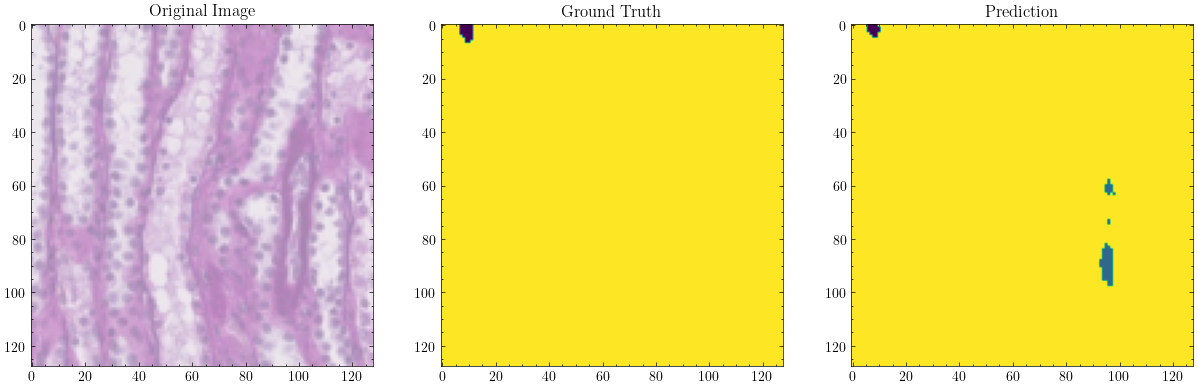

In [18]:
# Taking one batch from the validation loader
import numpy as np
data = iter(val_loader)
index = 2
for i in range(index):
    next(data)
images, masks = next(data)
images = images.to(device)
masks = torch.argmax(masks, dim=1).to(device)

# Predicting
with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Selecting the first image in the batch
image = images[0].cpu().permute(1, 2, 0).numpy()
mask = masks[0].cpu().numpy()
pred = preds[0].cpu().numpy()
print("Unique values in prediction:", np.unique(pred))

# Convert the tensor of predictions to a numpy array
preds_np = preds.cpu().numpy()

# Flatten the array if it's 3D, so we can count occurrences of each class label
preds_flat = preds_np.flatten()

# Use np.bincount to count occurrences of each class label
class_counts = np.bincount(preds_flat)

# Print the counts
print("Class counts in predictions:", class_counts)
print(pred)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow((image * 0.5) + 0.5)  # Reverting normalization
axes[0].set_title('Original Image')
axes[1].imshow(mask)
axes[1].set_title('Ground Truth')
axes[2].imshow(pred)
axes[2].set_title("Prediction")
# plt.text(-100, 300, f'Unique values in prediction: {np.unique(pred)}', fontsize=15)
# plt.text(-700, 320, f'Class counts in predictions: {class_counts}', fontsize=15)
#plt.text(0, 340, f'Weights: {weights.detach().cpu().numpy()}', fontsize=15)

plt.show()

best so far: channel weighted dice bce loss with weights: [1, 0, 0, 0]